## Data Science OMAT5204M 
## Summative Assessment 2

# _Modeling NHL Hall of Fame Induction with Supervised and Semi-Supervised Learning_


#### Student: 201804870

#### Email: od23kp@leeds.ac.uk

## Case study

This project explores the use of machine learning techniques to predict NHL player induction into the Hockey Hall of Fame based on historical career data. Using a supervised learning approach (Random Forest) and a semi-supervised alternative (Label Spreading), the study evaluates model performance, generalization, and practical trade-offs in the context of sports analytics.

The topic was selected during the 2025 Stanley Cup Finals, coinciding with increased public discussion around player legacies. As an Edmonton Oilers fan, this context provided timely motivation to explore how career trajectories align with Hall of Fame outcomes from a data-driven perspective. 

For additional context on the Hockey Hall of Fame and its induction criteria, please refer to Appendix A.

## 1. Aims, objectives and plan

#### Aim

The primary aim of this project is to develop and evaluate machine learning models to predict NHL player induction into the Hockey Hall of Fame using historical career data.

#### Objectives

1. **Data Preparation**: Collect and preprocess NHL player career statistics and Hall of Fame labels, ensuring data quality and suitability for modeling.

2. **Model Development**: Implement and train two models—a supervised Random Forest classifier and a semi-supervised Label Spreading algorithm—to classify players based on their likelihood of Hall of Fame induction.

3. **Model Evaluation**: Assess model performance using recall and F1-score, and analyze overfitting, generalization, and computational efficiency to identify the best performing model

#### Plan

<img src="project_plan.png" alt="Project Plan Mermaid Diagram" style="display: block; margin: auto; width: 35%; height: auto;">

## 2. Understanding the case study

###  Case study analysis
1. **Class Imbalance**
2. **Performance Disparities Across Positions**
3. **Redundant or Correlated Features** 
4. **High Data Volume and Feature Selection Complexity**

Please refer to Appendix B for Specific Findings and Solutions

## 3. Pre-processing applied

In [1]:
%%capture
pip install -r requirements.txt

In [2]:
%%capture
# Core libraries
import warnings
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns

# Network analysis
import networkx as nx
import community as community_louvain
from sklearn.metrics.pairwise import cosine_similarity

# Scikit-learn - Preprocessing & Utilities
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV,)
from scipy.stats import entropy

# Scikit-learn - Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import LabelSpreading

# Scikit-learn - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, precision_recall_curve, average_precision_score,
    classification_report, ConfusionMatrixDisplay,)


In [53]:
# Load datasets
df_master = pd.read_csv("Master.csv")
df_scoring = pd.read_csv("Scoring.csv")
df_awards = pd.read_csv("AwardsPlayers.csv")
df_hof = pd.read_csv("HOF.csv")

See Appendix C for Data Dictionary of column names

###  a) Merging, pivoting,  melting, and preparing labels

In [4]:
# Remove goalies from both datasets
df_master = df_master[df_master['pos'] != 'G']
df_scoring = df_scoring[df_scoring['pos'] != 'G']

# Aggregate scoring stats per player
agg_scoring = df_scoring.groupby("playerID", as_index=False).agg({
    "GP": "sum",
    "G": "sum",
    "A": "sum",
    "Pts": "sum",
    "+/-": "mean",
    "PIM": "sum",
    "PPG": "sum",
    "SHG": "sum",
    "GWG": "sum"
})

# Count awards per player 
award_counts = df_awards.groupby("playerID", as_index=False).size().rename(columns={"size": "num_awards"})

# Prepare HoF players and clean names
hof_players = df_hof.loc[df_hof['category'] == 'Player', ['name']].copy()
hof_players['name_clean'] = hof_players['name'].str.lower().str.strip()

df_master['name_clean'] = (df_master['firstName'].str.lower().str.strip() + ' ' + df_master['lastName'].str.lower().str.strip())

# Merge and create HoF flag
df_master = df_master.merge(hof_players[['name_clean']], how='left', on='name_clean', indicator=True)
df_master['HoF'] = (df_master['_merge'] == 'both').astype(int)
df_master.drop(columns=['_merge'], inplace=True)

# Select relevant biographical columns + HoF flag
bio = df_master[['playerID', 'birthYear', 'pos', 'height', 'weight', 'birthCountry', 'HoF']].copy()

# Merge aggregated scoring, bio, and awards data
df = agg_scoring.merge(bio, on='playerID', how='left').merge(award_counts, on='playerID', how='left')

# Fill missing values
df['num_awards'] = df['num_awards'].fillna(0)
df['HoF'] = df['HoF'].fillna(0)

# Reset index
df.reset_index(drop=True, inplace=True)

# Preview
df.head()

,playerID,GP,G,A,Pts,+/-,PIM,PPG,SHG,GWG,birthYear,pos,height,weight,birthCountry,HoF,num_awards
0,aaltoan01,151.0,11.0,17.0,28.0,-6.25,52.0,3.0,0.0,1.0,1975.0,C,73.0,210.0,Finland,0.0,0.0
1,abbeybr01,17.0,1.0,0.0,1.0,-3.00,12.0,0.0,0.0,0.0,1951.0,D,73.0,185.0,Canada,0.0,0.0
2,abbotre01,3.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1930.0,C,71.0,164.0,Canada,0.0,0.0
3,abdelju01,209.0,18.0,29.0,47.0,1.60,160.0,0.0,0.0,2.0,1987.0,L,73.0,195.0,USA,0.0,0.0
4,abelcl01,333.0,20.0,18.0,38.0,NaN,359.0,0.0,0.0,0.0,1900.0,D,73.0,225.0,USA,0.0,0.0


In [5]:
# Summary stats for numerical columns
print("Descriptive statistics for numerical features:")
print(df.describe().T)

Descriptive statistics for numerical features:
             count         mean         std     min          25%     50%  \
GP          6763.0   261.170339  321.660861     0.0    17.000000   111.0   
G           6763.0    49.000887   90.979118     0.0     1.000000    10.0   
A           6763.0    77.310365  136.666649     0.0     2.000000    17.0   
Pts         6763.0   126.311252  222.035684     0.0     3.000000    29.0   
+/-         5187.0    -1.248794    5.840961   -41.0    -3.666667    -1.0   
PIM         6763.0   235.982404  398.042952     0.0     7.000000    61.0   
PPG         6763.0    10.218542   26.133621     0.0     0.000000     0.0   
SHG         6763.0     1.421558    4.121404     0.0     0.000000     0.0   
GWG         6763.0     5.395535   12.043835     0.0     0.000000     0.0   
birthYear   6600.0  1956.285303   25.509275  1877.0  1945.000000  1962.0   
height      6581.0    71.983741    2.289837    65.0    70.000000    72.0   
weight      6581.0   190.549157   18.1261

In [6]:
# Count and percentage of Hall of Fame players
hof_counts = df['HoF'].value_counts()
hof_percent = df['HoF'].mean() * 100

print("Hall of Fame counts:\n", hof_counts)
print(f"\nPercentage of HoF players: {hof_percent:.2f}%")

Hall of Fame counts:
 HoF
0.0    6572
1.0     191
Name: count, dtype: int64

Percentage of HoF players: 2.82%


We can see above that there is a very small proportion of players that are inducted into the Hall of Fame. This logically makes sense, and will be addressed later in preprocessing as a problem of unbalanced classes. 

###  b)  Dealing with missing values (imputation, filtering) without leaking, if necessary.

In [7]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 playerID           0
GP                 0
G                  0
A                  0
Pts                0
+/-             1576
PIM                0
PPG                0
SHG                0
GWG                0
birthYear        163
pos              111
height           182
weight           182
birthCountry     295
HoF                0
num_awards         0
dtype: int64


Investigating the +/- (plus-minus) statistic, a substantial proportion of missing values were found particularly among players active prior to the 1960s. Because this feature was not consistently recorded across eras, its inclusion would introduce systematic bias and limit the comparability of players from different historical periods. In the interest of preserving dataset consistency and maintaining a broad temporal scope, +/- was excluded from the current analysis.

In [8]:
df = df.drop(columns=['+/-'])

In [9]:
# Select only numeric columns, excluding the target
numeric_cols = df.select_dtypes(include='number').columns.drop('HoF', errors='ignore')

# Fit and transform in-place
imputer = SimpleImputer(strategy='median')
df.loc[:, numeric_cols] = imputer.fit_transform(df[numeric_cols])

mode_country = df['birthCountry'].mode()[0]  # most frequent country
df.fillna({'birthCountry':mode_country}, inplace=True)

# Drop rows with missing position - likely a key feature
df = df.dropna(subset=['pos'])

`birthYear`, `height`, and `weight` columns were imputed using the median to preserve distribution shape while being robust to outliers. The categorical variable `birthCountry` was filled with its most frequent value to avoid introducing noise from rare or synthetic categories. Rows missing player position `pos` were dropped, as position is likely a key feature in modeling and could not be reliably imputed.

###  d) Dealing with duplicate values, if necessary.


In [10]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 1


In [11]:
# Drop duplicates
df = df.drop_duplicates()
df = df.reset_index()

Dropping single duplicated row

### f) Dealing with correlation and collinearity, if necessary.

<Axes: >

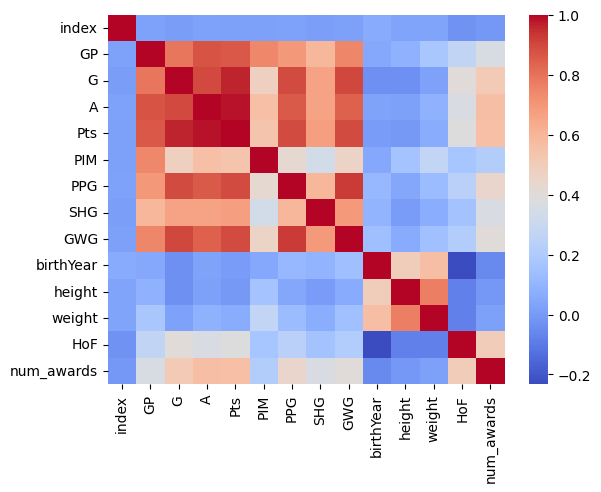

In [12]:
# Select numeric columns from the cleaned playoff data
X = df.select_dtypes(include='number')
sns.heatmap(X.corr(), annot=False, cmap="coolwarm")

See Appendix D for multicollinearity assessment

### g) Variance analysis, if necessary.

In [13]:
# Remove target column temporarily
X = df.drop(columns=['HoF'])
X = X.select_dtypes(include='number')

# Initialize the selector with a very small threshold
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)

# Show low-variance features
low_var_cols = X.columns[~selector.get_support()]
print("Low variance features:", low_var_cols)

Low variance features: Index([], dtype='object')


To ensure all input features contribute meaningful variation to the classification model, a low-variance filter was applied using sklearn's VarianceThreshold with a threshold of 0.01. No features were identified to have low variability.

### i) Appropriate feature extraction, if necessary.

In [14]:
# Creating Points per game variable
df['PPG_rate'] = df['Pts'] / df['GP']

This feature normalizes offensive productivity across players with varying career lengths, enabling fairer comparison. While total `Pts` captures overall contribution, it can be biased toward longevity. In contrast, `PPG_rate` emphasizes **efficiency**, which is particularly relevant when assessing Hall of Fame potential, where shorter but impactful careers are often recognized. 

Let's recheck that this new column did not create any new NA values.

In [15]:
df.isnull().sum()

index            0
playerID         0
GP               0
G                0
A                0
Pts              0
PIM              0
PPG              0
SHG              0
GWG              0
birthYear        0
pos              0
height           0
weight           0
birthCountry     0
HoF              0
num_awards       0
PPG_rate        27
dtype: int64

In [16]:
# Drop NA values
df = df.dropna()
df = df.reset_index()

These player were removed with NA PPG rates. This occurred as they had no games played, and therefore no points as well. Obviously these players would not be in contention for Hall of Fame status. 

### j) Identifying and dealing with class imbalance, if necessary.

In [17]:
# Count class distribution
df['HoF'].value_counts(normalize=True)

HoF
0.0    0.971316
1.0    0.028684
Name: proportion, dtype: float64

The target variable, HoF, is heavily imbalanced, with a small percentage of players being inducted into the Hall of Fame. This imbalance can bias the model toward predicting the majority class (non-HoF), leading to poor performance on identifying actual Hall of Famers. To mitigate this, I apply class_weight='balanced' during RF model training, which adjusts the loss function to penalize misclassifications from the minority class more heavily. Additionally, I evaluate model performance primarily using F1-score to balance precision and recall, ensuring the model is not only accurate overall but also effective at correctly identifying true Hall of Fame inductees without being overwhelmed by the dominant class.

### k) Identifying and dealing with outliers, if necessary.

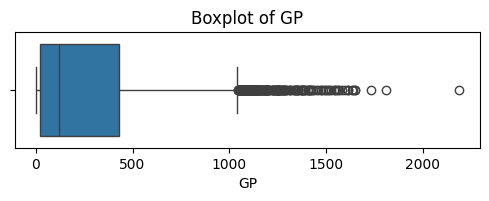

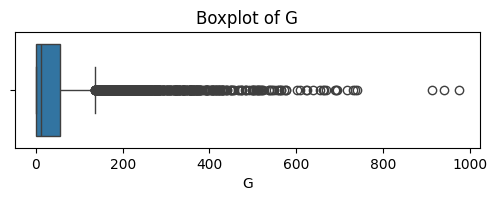

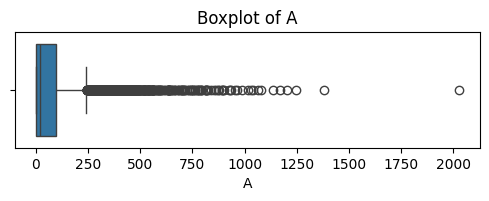

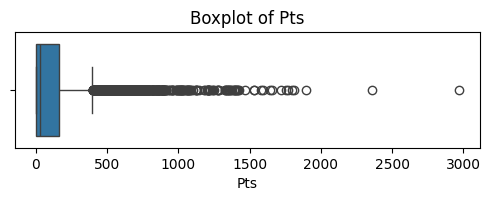

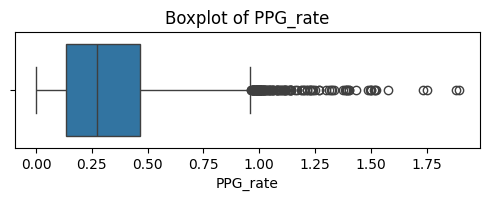

In [18]:
# Boxplot of selected continuous features
features = ['GP', 'G', 'A', 'Pts', 'PPG_rate']
for col in features:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

Outliers were inspected for core statistical features: `games played`, `goals`, `assists`, `points`, and `point per game rate`.Given the nature of the dataset — which profiles elite-level athletes — extreme values often reflect exceptional careers rather than data errors. For instance, very high point totals may correspond directly with Hall of Fame candidacy. As such, these values are preserved. Visual inspection via boxplots confirmed the presence of such outliers, but they were retained to ensure the model captures the full range of player performance. Additionally, The RF model is well-suited to handle these naturally. For the Label Spreading model, outliers can have a more significant impact, since it builds an affinity matrix based on feature-space similarity. To mitigate this, **Principal Component Analysis (PCA)** will be applied prior to training to reduce dimensionality and smooth out the influence of extreme values, while still preserving overall structure in the data.

### l) Categorical and numerical encoding if necessary.

In [19]:
# For Random Forest (label encoding)
le_position = LabelEncoder()
df['pos_encoded'] = le_position.fit_transform(df['pos'])

le_country = LabelEncoder()
df['birthCountry_encoded'] = le_country.fit_transform(df['birthCountry'])

Categorical variables were encoded using `LabelEncoder` to convert text values into numeric format suitable for the Random Forest model.

In [ ]:
df.head() # final dataset 

,level_0,index,playerID,GP,G,A,Pts,PIM,PPG,SHG,...,birthYear,pos,height,weight,birthCountry,HoF,num_awards,PPG_rate,pos_encoded,birthCountry_encoded
0,0,0,aaltoan01,151.0,11.0,17.0,28.0,52.0,3.0,0.0,...,1975.0,C,73.0,210.0,Finland,0.0,0.0,0.185430,0,11
1,1,1,abbeybr01,17.0,1.0,0.0,1.0,12.0,0.0,0.0,...,1951.0,D,73.0,185.0,Canada,0.0,0.0,0.058824,4,6
2,2,2,abbotre01,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1930.0,C,71.0,164.0,Canada,0.0,0.0,0.000000,0,6
3,3,3,abdelju01,209.0,18.0,29.0,47.0,160.0,0.0,0.0,...,1987.0,L,73.0,195.0,USA,0.0,0.0,0.224880,8,40
4,4,4,abelcl01,333.0,20.0,18.0,38.0,359.0,0.0,0.0,...,1900.0,D,73.0,225.0,USA,0.0,0.0,0.114114,4,40


In [21]:
# Select only numeric columns, including encoded features
features = [
    'GP', 'G', 'A', 'Pts', 'PIM', 'PPG', 'SHG', 'GWG',
    'birthYear', 'height', 'weight', 'num_awards', 'PPG_rate',
    'pos_encoded', 'birthCountry_encoded'
]

X = df[features]
y = df['HoF']

In [22]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=8
)

## 4. Technique 1 (Random Forest)

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process

Please see Appendix E for motivation and schematic figure.

### b) Setting hyperparameters (rationale)


In [23]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],       # Tree count
    'max_features': [0.2, 0.3, 0.4, 'sqrt', 'log2'], # Feature subsets per split
    'max_samples': [0.5, 0.6, 0.7, 0.8, None],       # Subsample size (None = full set)
    'min_samples_leaf': [1, 2, 3, 4, 5],             # Leaf size controls complexity
}

### c) Optimising hyperparameters appropriately


In [24]:
# Initialize model
rf = RandomForestClassifier(random_state=8, class_weight='balanced', n_jobs=-1)

# Set up grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1', 
    verbose=2,
    n_jobs=-1
)

In [25]:
# Fit to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=8),
             n_jobs=-1,
             param_grid={'max_features': [0.2, 0.3, 0.4, 'sqrt', 'log2'],
                         'max_samples': [0.5, 0.6, 0.7, 0.8, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='f1', verbose=2)

In [26]:
# Best model
best_rf = grid_search.best_estimator_

### d) Performance metrics for training set

In [ ]:
# Predict and scores (test to be used later)
y_train_pred_rf = best_rf.predict(X_train)
train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)

y_test_pred_rf = best_rf.predict(X_test)
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

# Print classification report 
print(classification_report(y_train, y_train_pred_rf, target_names=["Not HoF", "HoF"]))

              precision    recall  f1-score   support

     Not HoF       1.00      1.00      1.00      4503
         HoF       0.89      1.00      0.94       133

    accuracy                           1.00      4636
   macro avg       0.94      1.00      0.97      4636
weighted avg       1.00      1.00      1.00      4636



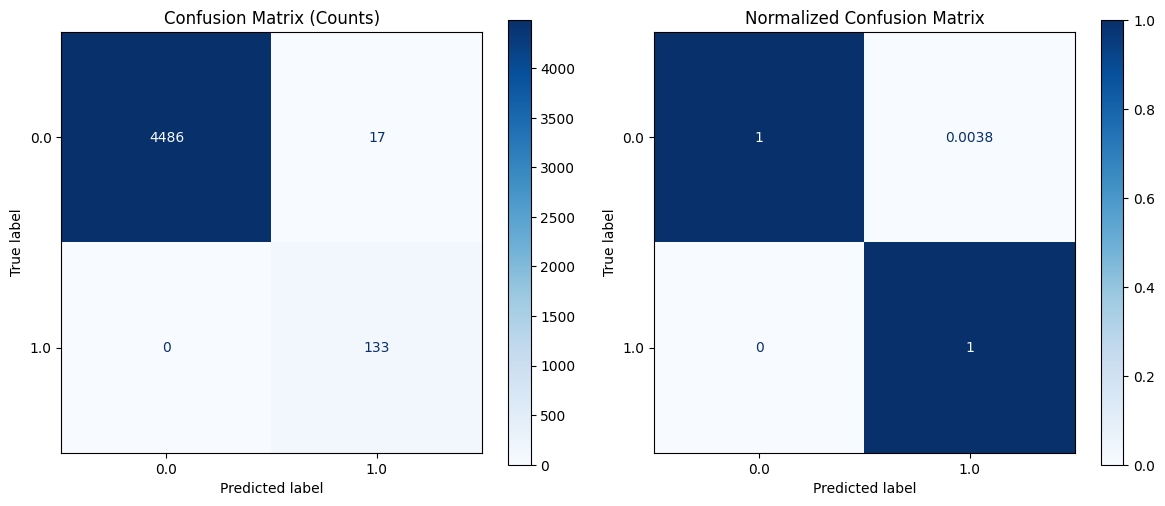

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_train,
    y_train,
    normalize=None,   # No normalization = raw counts
    cmap='Blues',
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)")

# Normalized confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_train,
    y_train,
    normalize='true',  # Normalize by true label (recall)
    cmap='Blues',
    ax=axes[1]
)
axes[1].set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

The Random Forest model achieves near-perfect performance on the training set, with an F1-score of **1.00** for the majority class and **0.94** for the Hall of Fame class. While this indicates the model has successfully learned complex patterns in the data — including the minority class — such high scores, particularly on training data, may signal overfitting. The model exhibits perfect recall for Hall of Famers (**1**), meaning it does not misses positive cases,However, this performance must be interpreted cautiously and validated against test set metrics to ensure generalizability.

### e) Other items necessary for the technique.

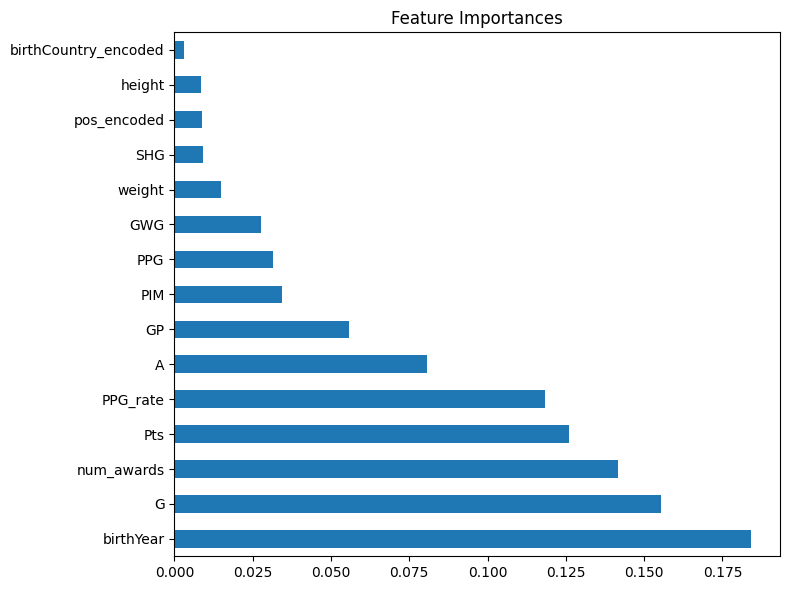

In [29]:
# Feature importance graph
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='barh', figsize=(8,6), title='Feature Importances')
plt.tight_layout()
plt.show()

`birthYear` appears to be the most important feature, followed by `num_awards` and `G`. 

In [30]:
# Analyze individual trees in the forest
tree_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
tree_nodes = [estimator.tree_.node_count for estimator in best_rf.estimators_]

print(f"Average tree depth: {np.mean(tree_depths):.2f}")
print(f"Average number of nodes: {np.mean(tree_nodes):.2f}")


Average tree depth: 11.80
Average number of nodes: 113.10


On average, each tree in the forest contains about 11-12 levels and approximately 100 nodes. This is a moderate depth and split that indicates a good balance between complexity and generalization. 

Nearly 0.5 means the initial label distribution at the root is close to uniform. This means that balancing the classes had an effect for the training set.

In [31]:
# Average Information Gain at Root Split
def info_gain(tree):
    left = tree.tree_.children_left[0]
    right = tree.tree_.children_right[0]
    n_node_samples = tree.tree_.n_node_samples
    impurity = tree.tree_.impurity

    p_left = n_node_samples[left] / n_node_samples[0]
    p_right = n_node_samples[right] / n_node_samples[0]
    
    return impurity[0] - (p_left * impurity[left] + p_right * impurity[right])

gains = [info_gain(est) for est in best_rf.estimators_]
print(f"Average information gain at root split: {np.mean(gains):.4f}")


Average information gain at root split: 0.2178


The first split reduces Gini impurity by ~0.22 on average. This is a solid amount of discriminatory power. 

## 5. Technique 2 (Semi-Suprervised Label Spreading)

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process


Please see Appendix F for motivation and schematic figure of the process.

### b) Setting hyperparameters (rationale)


In [32]:
# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95, random_state=8)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Mask 80% of training labels for semi-supervised learning
y_train_masked = np.copy(y_train)
mask_ratio = 0.8
num_mask = int(len(y_train) * mask_ratio)
np.random.seed(8)
mask_indices = np.random.choice(len(y_train), size=num_mask, replace=False)
y_train_masked[mask_indices] = -1 

In [33]:
print(f"Original feature count: {X_train.shape[1]}")
print(f"PCA components retained: {X_train_pca.shape[1]}")

Original feature count: 15
PCA components retained: 9


Features were reduced from 15 -> 9. This is not substantial but does help with the case study issue of multicollinearity of features such as assists, goals, and points. 

### c) Optimising hyperparameters appropriately


In [34]:
def tune_labelspread(
    X_train,
    y_train,
    kernel,
    param_values,
    max_iter=3000,
    cv_splits=5,
    random_state=8
):
    """
    Tune LabelSpreading hyperparameters (either 'knn' or 'rbf') using stratified CV on labeled and unlabeled data.

    Args:
        X_train: np.array, features including labeled data
        y_train: np.array, labels with unlabeled as -1
        kernel: 'knn' or 'rbf'
        param_values: list of values for n_neighbors (knn) or gamma (rbf)
        max_iter: max iterations for LabelSpreading
        cv_splits: number of CV folds
        random_state: random seed

    Returns:
        pd.DataFrame with columns: kernel, param, f1_mean, precision_mean, recall_mean, accuracy_mean, roc_auc_mean
    """

    results = []

    # Extract labeled and unlabeled subsets
    labeled_mask = y_train != -1
    X_labeled = X_train[labeled_mask]
    y_labeled = y_train[labeled_mask]

    X_unlabeled = X_train[~labeled_mask]

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    for val in param_values:
        # Collect metrics
        f1_scores = []
        roc_aucs = []
        precision_scores = []
        recall_scores = []
        accuracy_scores = []

        for train_idx, val_idx in cv.split(X_labeled, y_labeled):
            X_train_labeled = X_labeled[train_idx]
            y_train_labeled = y_labeled[train_idx]
            X_val = X_labeled[val_idx]
            y_val = y_labeled[val_idx]

            # Combine labeled training + unlabeled for fit
            X_train_full = np.concatenate([X_train_labeled, X_unlabeled])
            y_train_full = np.concatenate([y_train_labeled, np.full(len(X_unlabeled), -1)])

            # Instantiate model with proper params
            if kernel == 'knn':
                model = LabelSpreading(kernel=kernel, n_neighbors=val, max_iter=max_iter)
            elif kernel == 'rbf':
                model = LabelSpreading(kernel=kernel, gamma=val, max_iter=max_iter)
            else:
                raise ValueError("kernel must be 'knn' or 'rbf'")

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train_full, y_train_full)

            y_pred = model.predict(X_val)
            
            # Compute and append F1
            f1 = f1_score(y_val, y_pred, pos_label=1)
            if not np.isnan(f1):
                f1_scores.append(f1)
            
            # Precision
            prec = precision_score(y_val, y_pred, zero_division=0)
            if not np.isnan(prec):
                precision_scores.append(prec)
            
            # Recall
            rec = recall_score(y_val, y_pred, zero_division=0)
            if not np.isnan(rec):
                recall_scores.append(rec)
            
            # Accuracy
            acc = accuracy_score(y_val, y_pred)
            if not np.isnan(acc):
                accuracy_scores.append(acc)
            
            # ROC AUC only if valid
            if len(np.unique(y_val)) > 1:
                val_proba = model.predict_proba(X_val)[:, 1]
                if not np.isnan(val_proba).any():
                    roc = roc_auc_score(y_val, val_proba)
                    if not np.isnan(roc):
                        roc_aucs.append(roc)

        results.append({
            'kernel': kernel,
            'param': val,
            'f1_mean': np.nanmean(f1_scores),
            'precision_mean': np.nanmean(precision_scores),
            'recall_mean': np.nanmean(recall_scores),
            'accuracy_mean': np.nanmean(accuracy_scores),
            'roc_auc_mean': np.nanmean(roc_aucs)
        })


    return pd.DataFrame(results)


In [35]:
# Define tuning space
rbf_gammas = np.linspace(2, 30, 29)
knn_neighbors = list(range(2, 30))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    df_rbf = tune_labelspread(X_train_pca, y_train_masked, 'rbf', rbf_gammas)
    df_knn = tune_labelspread(X_train_pca, y_train_masked, 'knn', knn_neighbors)

df_tuning = pd.concat([df_rbf, df_knn], ignore_index=True).sort_values(by='f1_mean', ascending=False)
print(df_tuning.head(10))

   kernel  param   f1_mean  precision_mean  recall_mean  accuracy_mean  \
0     rbf    2.0  0.526768        0.676667     0.452381       0.975217   
32    knn    5.0  0.524545        0.760000     0.419048       0.976286   
34    knn    7.0  0.486032        0.883333     0.352381       0.976292   
33    knn    6.0  0.474286        0.900000     0.352381       0.976292   
44    knn   17.0  0.467619        1.000000     0.319048       0.977367   
42    knn   15.0  0.467619        1.000000     0.319048       0.977367   
41    knn   14.0  0.467619        1.000000     0.319048       0.977367   
2     rbf    4.0  0.463636        0.630000     0.385714       0.973066   
1     rbf    3.0  0.463636        0.630000     0.385714       0.973066   
36    knn    9.0  0.454286        0.950000     0.319048       0.976292   

    roc_auc_mean  
0       0.904894  
32      0.952103  
34      0.968788  
33      0.966554  
44      0.970324  
42      0.971436  
41      0.967718  
2       0.897518  
1       0.8968

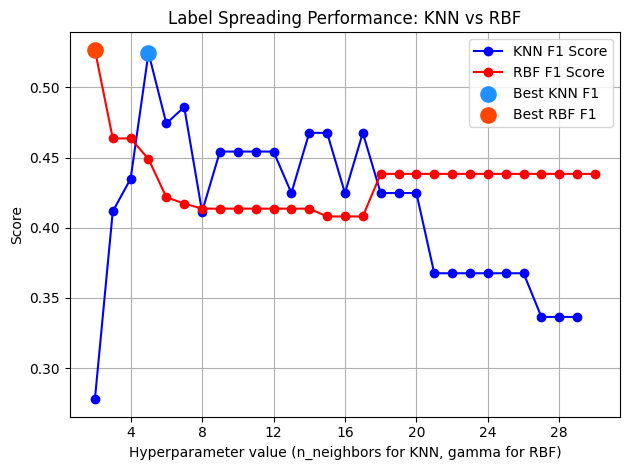

In [ ]:
# Plot F1 scores
plt.plot(df_knn['param'], df_knn['f1_mean'], marker='o', label='KNN F1 Score', color='blue')
plt.plot(df_rbf['param'], df_rbf['f1_mean'], marker='o', label='RBF F1 Score', color='red')

# Mark best F1 points
best_knn = df_knn.loc[df_knn['f1_mean'].idxmax()]
best_rbf = df_rbf.loc[df_rbf['f1_mean'].idxmax()]

plt.scatter(best_knn['param'], best_knn['f1_mean'], color='dodgerblue', s=120, label='Best KNN F1', zorder=5)
plt.scatter(best_rbf['param'], best_rbf['f1_mean'], color='orangered', s=120, label='Best RBF F1', zorder=5)

# Axis labels
plt.xlabel("Hyperparameter value (n_neighbors for KNN, gamma for RBF)")
plt.ylabel("Score")
plt.title("Label Spreading Performance: KNN vs RBF")

# Make x-axis ticks integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
best_row = df_tuning.sort_values(by='f1_mean', ascending=False).iloc[0]
best_param = best_row['param']
best_kernel = best_row['kernel']

print(f"Best kernel: {best_kernel}, Best param: {best_param}")

Best kernel: rbf, Best param: 2.0


### d) Performance metrics for training set

In [ ]:
model_ls = LabelSpreading(kernel= best_kernel, n_neighbors=int(best_param), max_iter=10000)
model_ls.fit(X_train_pca, y_train_masked)

# Masked labels used for training
y_masked = y_train_masked

# Indices of labeled points in the training set
labeled_indices = np.where(y_masked != -1)[0]

# True labels for labeled training points
train_true = y_train.iloc[labeled_indices].astype(int)

# Model's predicted label distributions for *all* training points
train_probs_all = model_ls.label_distributions_

# Select only the labeled points' predicted distributions
train_probs = train_probs_all[labeled_indices]

# Confidence in correct class for labeled points
train_correct_conf = train_probs[np.arange(len(train_true)), train_true]

print("Mean Confidence (Correct Class):", np.mean(train_correct_conf))
print("Log Loss (Training):", log_loss(train_true, train_probs))

Mean Confidence (Correct Class): 0.9999987947704357
Log Loss (Training): 1.205460642140251e-06


The Label Spreading model achieved near perfect confidence and near-zero log loss on the training set:

In [39]:
print(f"F1 Score: {best_row['f1_mean']:.3f}")
print(f"Precision: {best_row['precision_mean']:.3f}")
print(f"Recall: {best_row['recall_mean']:.3f}")
print(f"ROC AUC: {best_row['roc_auc_mean']:.3f}")

F1 Score: 0.527
Precision: 0.677
Recall: 0.452
ROC AUC: 0.905


### e) Other items necessary for the technique.

In [40]:
# Build similarity matrix on training data only
similarity_matrix = cosine_similarity(X_train_pca)

# Initialize empty graph
G = nx.Graph()

# Add nodes for each training sample
for i in range(len(X_train_pca)):
    G.add_node(i)

# Add edges based on similarity threshold
threshold = 0.8
for i in range(len(X_train_pca)):
    for j in range(i + 1, len(X_train_pca)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])


Detected 9 communities


C:\Users\kimbe\AppData\Local\Temp\ipykernel_31508\1838963569.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_communities)


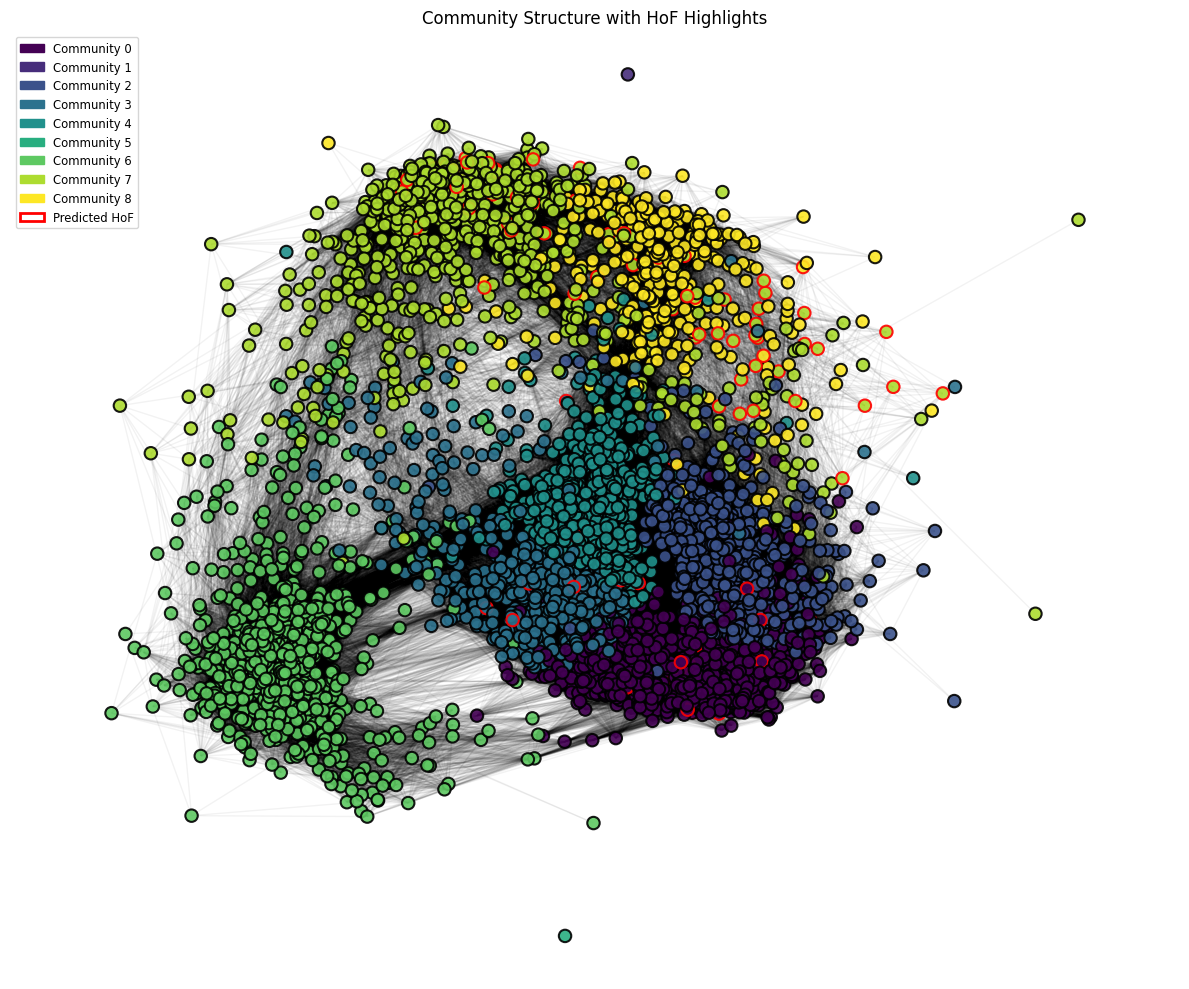

In [ ]:
# Detect communities
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities")

# Color by community
cmap = cm.get_cmap('viridis', num_communities)
community_colors = [cmap(partition[node]) for node in G.nodes()]

# Predicted HoF labels
y_train_pred_ls = model_ls.transduction_  # 0 or 1

# Use edgecolors to highlight HoF
edge_colors = ['red' if y_train_pred_ls[i] == 1 else 'black' for i in range(len(G.nodes))]

# Layout
pos = nx.spring_layout(G,k=0.15, iterations=50, seed=8)

# Plot
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(
    G, pos,
    node_color=community_colors,
    edgecolors=edge_colors,  # HoF gets red border
    node_size=80,
    linewidths=1.5,
    alpha=0.9
)
nx.draw_networkx_edges(G, pos, alpha=0.05)

# Generate legend patches for each community
community_patches = [
    mpatches.Patch(color=cmap(i), label=f"Community {i}")
    for i in range(num_communities)
]

# Add HoF edge color legend
hof_patch = mpatches.Patch(edgecolor='red', facecolor='white', label='Predicted HoF', linewidth=2)

# Combine all legend handles
legend_handles = community_patches + [hof_patch]

# Draw the legend
plt.legend(handles=legend_handles, loc='best', frameon=True, fontsize='small')
plt.title("Community Structure with HoF Highlights")
plt.axis('off')
plt.tight_layout()
plt.show()

While the Label Spreading graph is used internally to propagate labels, I visualized the cosine similarity graph instead. This approach better highlights global structure and community clusters among NHL players based on their career statistics. The seven main groups can easily be visualized and distinguished in the main cluster. 

In [42]:
# Group nodes by community
community_hof_counts = defaultdict(lambda: {'HoF': 0, 'NotHoF': 0})

for node, community in partition.items():
    label = y_train_pred_ls[node]
    if label == 1:
        community_hof_counts[community]['HoF'] += 1
    else:
        community_hof_counts[community]['NotHoF'] += 1

# Convert to DataFrame
rows = []
for comm, counts in community_hof_counts.items():
    total = counts['HoF'] + counts['NotHoF']
    rows.append({
        'Community': comm,
        'Total Nodes': total,
        'HoF Count': counts['HoF'],
        'Not HoF Count': counts['NotHoF'],
        'HoF %': round(counts['HoF'] / total * 100, 1)
    })

df_comm_summary = pd.DataFrame(rows).sort_values(by='HoF %', ascending=False)

# Display table
print(df_comm_summary.to_string(index=False))

 Community  Total Nodes  HoF Count  Not HoF Count  HoF %
         7          874         80            794    9.2
         3          494         12            482    2.4
         0          866         20            846    2.3
         8          330          2            328    0.6
         2          616          0            616    0.0
         4          669          0            669    0.0
         6          785          0            785    0.0
         1            1          0              1    0.0
         5            1          0              1    0.0


In [43]:
# Identify top community
top_row = df_comm_summary.iloc[0]
top_comm = int(top_row['Community'])
top_hof_rate = top_row['HoF %']

# Identify low HoF rate but nonzero communities (excluding the top)
low_hof_communities = df_comm_summary[
    (df_comm_summary['HoF %'] > 0) & 
    (df_comm_summary['HoF %'] < top_hof_rate)
]['Community'].astype(int).tolist()

# Zero HoF communities (with more than 1 member)
zero_hof_communities = df_comm_summary[
    (df_comm_summary['HoF %'] == 0) & 
    (df_comm_summary['Total Nodes'] > 1)
]['Community'].astype(int).tolist()

# Identify single-member communities
single_node_communities = df_comm_summary[
    df_comm_summary['Total Nodes'] == 1
]['Community'].astype(int).tolist()

# Update-able comment
summary_comment = f"""
The model identifies a relatively elite group in Community {top_comm}, with a {top_hof_rate}% HoF prediction rate — the highest among all detected communities. This suggests that players in this cluster share strong similarities associated with Hall of Fame–level performance.

{"Communities " + ", ".join(map(str, low_hof_communities)) + " show small but non-zero HoF prediction rates." if low_hof_communities else ""}

{"Notably, several communities (" + ", ".join(map(str, zero_hof_communities)) + ") contain hundreds of players with zero HoF predictions, reflecting a clear separation in the feature space and strong confidence from the model in excluding those groups from elite status." if zero_hof_communities else ""}

{"Communities " + " and ".join(map(str, single_node_communities)) + " only contain a single player, showcasing significantly different similarity outcomes." if single_node_communities else ""}
""".strip()

print(summary_comment)

The model identifies a relatively elite group in Community 7, with a 9.2% HoF prediction rate — the highest among all detected communities. This suggests that players in this cluster share strong similarities associated with Hall of Fame–level performance.

Communities 3, 0, 8 show small but non-zero HoF prediction rates.

Notably, several communities (2, 4, 6) contain hundreds of players with zero HoF predictions, reflecting a clear separation in the feature space and strong confidence from the model in excluding those groups from elite status.

Communities 1 and 5 only contain a single player, showcasing significantly different similarity outcomes.


### f) Deal with class imbalance, if necessary, if not done above.

Although `LabelSpreading` does not support class weighting directly, I addressed class imbalance by:

- Performing hyperparameter tuning using **stratified cross-validation**, ensuring class proportions are preserved across folds.
- Using **F1 score** as the primary evaluation metric during model selection, which balances precision and recall and is more informative for imbalanced data.
- Analyzing community-level HoF distributions post-prediction to validate that the model is still able to detect meaningful HoF groupings despite the imbalance.

## 6. Comparison of metrics performance for testing

### a) Use of cross validation for both techniques to deal with overfitting model selection and model comparison.

## Random Forest 
- Class Weighting to Handle Imbalance

Set `class_weight='balanced'` in the model to give more weight to the minority HoF class, reducing the risk of biased predictions toward the majority.


- Cross Validation with Grid Search

I used 5-fold cross-validation during hyperparameter tuning to assess model performance across multiple data splits. This ensured that the model generalized beyond a single train-test split and prevented overfitting to training data.

- Gini Impurity

In [44]:
# Find gini impurity at root nodes
root_ginis = [tree.tree_.impurity[0] for tree in best_rf.estimators_]
print(f"Average Gini impurity at root nodes: {np.mean(root_ginis):.4f}")

Average Gini impurity at root nodes: 0.4990


The rf model controls overfitting mainly through randomness in feature selection (max_features=0.3) and ensemble averaging across many trees.

## Label Spreading
- Cross-Validation for Hyperparameter Tuning

I tuned the `n_neighbours`/ `gamma` parameter along with the respective kernel using 5-fold stratified cross-validation on the labeled portion of the data, helping to choose a kernel width that generalizes well without fitting noise.

- Use of Semi-Supervised Learning with Unlabeled Data

By incorporating a large portion of unlabeled data during training, the LabelSpreading model is encouraged to generalize from broader patterns in the data rather than overfitting to the limited labeled set.

- Dimensionality Reduction via PCA

This helps prevent overfitting by reducing noise and redundancy in the input space

### b) Use appropriate metrics for testing set

In [45]:
# Predict test labels - RF calculated earlier in code
y_test_pred_ls = model_ls.predict(X_test_pca)

c:\Users\kimbe\OneDrive\Documents\Education\Leeds\Course 9 - Data Science\Week 7\.venv\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


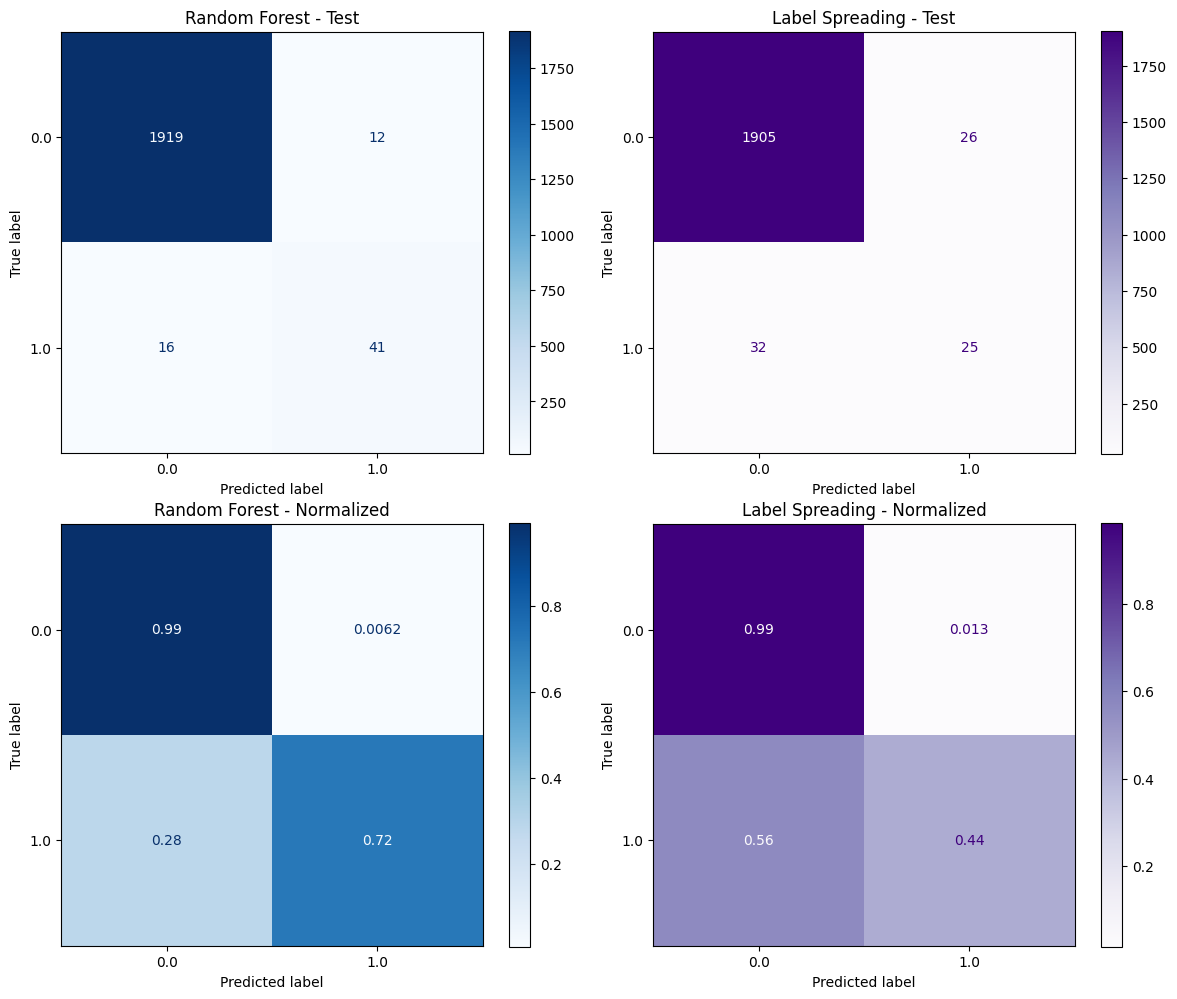

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top row: raw confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf, ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title("Random Forest - Test")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_ls, ax=axes[0, 1], cmap='Purples')
axes[0, 1].set_title("Label Spreading - Test")

# Bottom row: normalized confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf, ax=axes[1, 0], cmap='Blues', normalize='true')
axes[1, 0].set_title("Random Forest - Normalized")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_ls, ax=axes[1, 1], cmap='Purples', normalize='true')
axes[1, 1].set_title("Label Spreading - Normalized")

plt.tight_layout()
plt.show()


We can see in these confusion matrices that the random forest model is a better predictor of the HoF class, the normalized graphs show a much higher percentage of HoF accuracy in the Rf model.

In [47]:
# Bar graph comparison of metrics
# Get reports as dicts
report_rf = classification_report(y_test, y_test_pred_rf, output_dict=True)
report_ls = classification_report(y_test, y_test_pred_ls, output_dict=True)

keys = ['0.0', '1.0', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

# Extract into a dataframe
df_compare = pd.DataFrame({
    'Metric': [],
    'Class': [],
    'Random Forest': [],
    'LabelSpreading': []
})

for label in keys:
    for metric in metrics:
        df_compare = pd.concat([df_compare, pd.DataFrame([{
            'Metric': metric.title(),
            'Class': 'HoF' if label == '1.0' else 'Not HoF' if label == '0.0' else label.title(),
            'Random Forest': report_rf[label][metric],
            'LabelSpreading': report_ls[label][metric]
        }])], ignore_index=True)

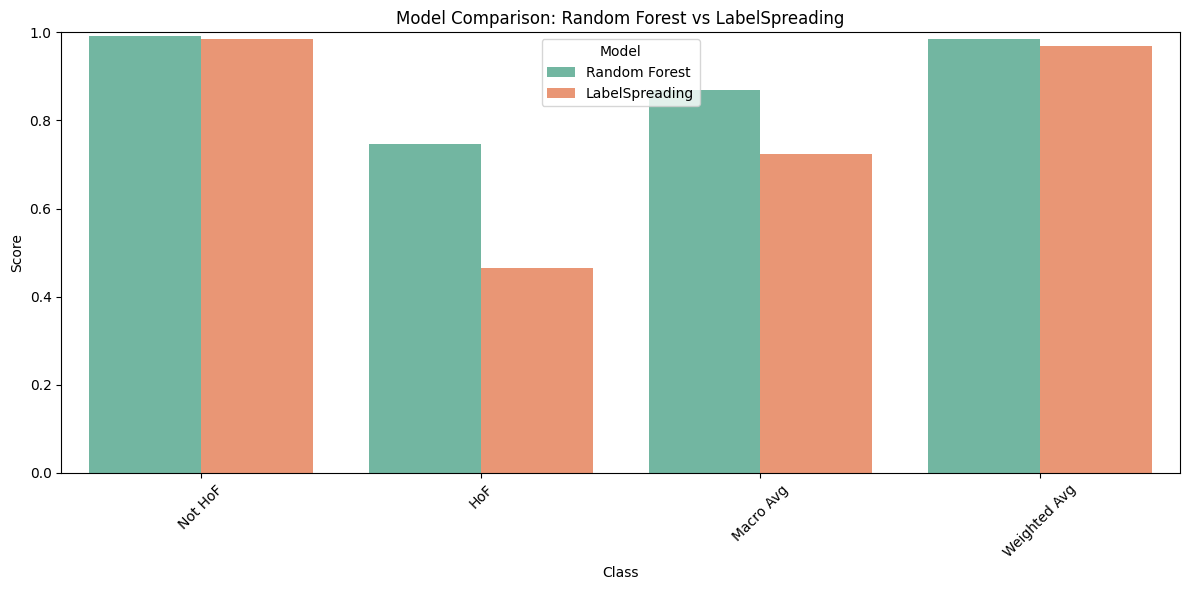

In [48]:
# Plot bar graph comparison of metrics
plt.figure(figsize=(12, 6))
df_melt = df_compare.melt(id_vars=['Metric', 'Class'], var_name='Model', value_name='Score')

sns.barplot(
    data=df_melt,
    x='Class',
    y='Score',
    hue='Model',
    palette='Set2',
    errorbar=None,
    dodge=True
)
plt.title("Model Comparison: Random Forest vs LabelSpreading")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [49]:
# Numerical table of metrics
print(df_compare.round(3).to_string(index=False))

   Metric        Class  Random Forest  LabelSpreading
Precision      Not HoF          0.992           0.983
   Recall      Not HoF          0.994           0.987
 F1-Score      Not HoF          0.993           0.985
Precision          HoF          0.774           0.490
   Recall          HoF          0.719           0.439
 F1-Score          HoF          0.745           0.463
Precision    Macro Avg          0.883           0.737
   Recall    Macro Avg          0.857           0.713
 F1-Score    Macro Avg          0.869           0.724
Precision Weighted Avg          0.985           0.969
   Recall Weighted Avg          0.986           0.971
 F1-Score Weighted Avg          0.986           0.970


The table above compares the performance of the Random Forest and Label Spreading models across several evaluation metrics. Overall, the Random Forest model consistently outperforms the semi-supervised model, particularly on the minority **Hall of Fame (HoF)** class.

For the HoF class, Random Forest achieves an **F1-score of 0.745**, significantly higher than the Label Spreading model's, indicating better balance between precision and recall. The **recall of 0.719** suggests that Random Forest is able to identify more actual Hall of Fame players, which is a key objective of the task. In contrast, the RBF model exhibits a lower recall, missing a substantial portion of true positive cases.

While both models perform well on the majority class (Not HoF), the macro-averaged scores reveal a clearer distinction: the Random Forest model demonstrates stronger balance across both classes compared to the RBF model. This is particularly important in imbalanced classification settings, as macro metrics assign equal importance to each class, highlighting the Random Forest’s superior ability to generalize beyond the dominant category.

When considering weighted averages — which adjust for class imbalance by giving more influence to the majority class — both models show strong overall performance. However, Random Forest still holds a consistent advantage, delivering higher precision and recall without compromising overall accuracy.

Overall, Random Forest provides better classification balance and reliability, especially for the minority HoF class.

In [50]:
df_agreement = pd.DataFrame({
    'True_Label': y_test,
    'RF_Pred': y_test_pred_rf,
    'LS_Pred': y_test_pred_ls
})

# Did the models agree?
df_agreement['Agree'] = df_agreement['RF_Pred'] == df_agreement['LS_Pred']

# Which model (if any) was correct
df_agreement['RF_Correct'] = df_agreement['RF_Pred'] == df_agreement['True_Label']
df_agreement['LS_Correct'] = df_agreement['LS_Pred'] == df_agreement['True_Label']

# Agreement rate
agree_rate = df_agreement['Agree'].mean()

# Where both agree AND correct
both_correct = ((df_agreement['RF_Correct']) & (df_agreement['LS_Correct'])).sum()

# Where both agree but are wrong
both_wrong = ((df_agreement['RF_Pred'] == df_agreement['LS_Pred']) & 
              (df_agreement['RF_Correct'] == False)).sum()

# Disagree and RF is correct
rf_better = ((df_agreement['RF_Correct']) & (~df_agreement['LS_Correct'])).sum()

# Disagree and LS is correct
rbf_better = ((~df_agreement['RF_Correct']) & (df_agreement['LS_Correct'])).sum()

print(f"Agreement Rate: {agree_rate:.2%}")
print(f"Both models correct: {both_correct}")
print(f"Both models wrong (agreed on wrong label): {both_wrong}")
print(f"Disagree: RF correct: {rf_better}, LS correct: {rbf_better}")

Agreement Rate: 97.18%
Both models correct: 1917
Both models wrong (agreed on wrong label): 15
Disagree: RF correct: 43, LS correct: 13


To better understand how the two models behave on the test set, we examined the agreement and disagreement patterns between Random Forest and Label Spreading predictions.

These results suggest that while the models generally agree, Random Forest tends to outperform Label Spreading in edge cases, particularly when classifying more difficult or ambiguous players.

### c) Use an appropriate model selection visualization curve (ROC, PR etc.) that is suitable for the problem at hand

Given the imbalanced nature of our classification problem — where predicting Hall of Fame (HoF) players (positive class) is much harder and rarer than predicting non-HoF — we use a **Precision-Recall (PR) Curve** for model evaluation.

Unlike ROC curves, PR curves focus on the model's ability to correctly identify the positive class without being overwhelmed by the abundance of true negatives. This is especially important when false positives and false negatives carry different costs, as is the case when identifying top-tier talent.

The PR curves below compare the Random Forest and Label Spreading models. Larger area under the curve and curves that stay near the top right corner indicate better precision-recall trade-off.

c:\Users\kimbe\OneDrive\Documents\Education\Leeds\Course 9 - Data Science\Week 7\.venv\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


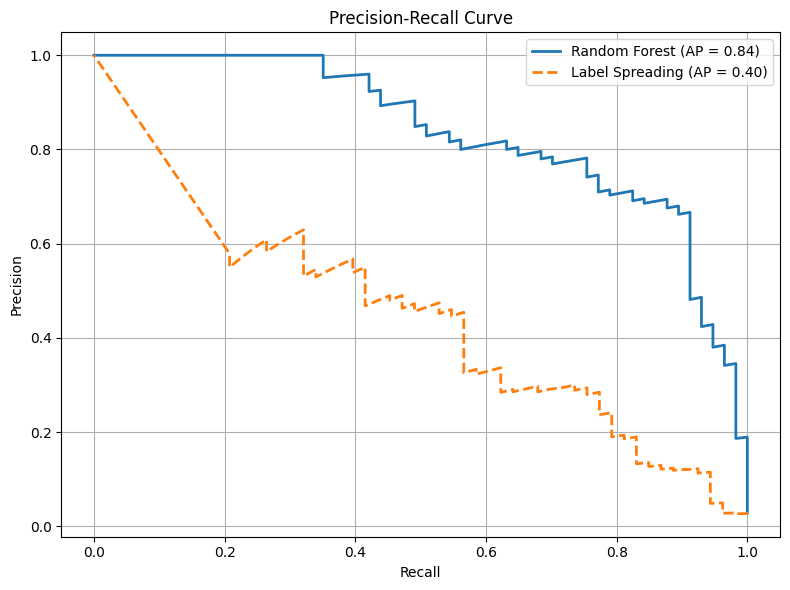

In [51]:
# Probabilities for the test set using RF
test_proba_rf = best_rf.predict_proba(X_test)[:, 1]
rf_probs = test_proba_rf
# Probabilities for the test set using LS model
ls_probs = model_ls.predict_proba(X_test_pca)[:, 1]

# Filter both y_test and ls_probs for potential isolated nodes
mask = ~np.isnan(ls_probs)
y_test_filtered = y_test[mask]
ls_probs_filtered = ls_probs[mask]

# Compute precision-recall
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
precision_ls, recall_ls, _ = precision_recall_curve(y_test_filtered, ls_probs_filtered)

# AUC-PR
auc_rf = average_precision_score(y_test, rf_probs)
auc_rbf = average_precision_score(y_test_filtered, ls_probs_filtered)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {auc_rf:.2f})', lw=2)
plt.plot(recall_ls, precision_ls, label=f'Label Spreading (AP = {auc_rbf:.2f})', lw=2, linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The Precision-Recall curve demonstrates that the Random Forest model significantly outperforms Label Spreading model in identifying Hall of Fame players. With an average precision of 0.76 compared to 0.53, the RF model maintains both higher precision and recall across thresholds, making it more effective in this highly imbalanced classification setting.

### d) Checking for overfitting

In [ ]:
# Compute ls evaluation metrics
train_acc_ls = accuracy_score(y_train, y_train_pred_ls)
train_f1_ls = f1_score(y_train, y_train_pred_ls, average='macro')

test_acc_ls = accuracy_score(y_test, y_test_pred_ls)
test_f1_ls = f1_score(y_test, y_test_pred_ls, average='macro')

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Random Forest', 'Label Spreading', 'Label Spreading'],
    'Split': ['Train', 'Test', 'Train', 'Test'],
    'Accuracy': [train_acc_rf, test_acc_rf, train_acc_ls, test_acc_ls],
    'F1 Score': [train_f1_rf, test_f1_rf, train_f1_ls, test_f1_ls]
})

# Round and display
print(results_df.round(3).to_string(index=False))

          Model Split  Accuracy  F1 Score
  Random Forest Train     0.996     0.969
  Random Forest  Test     0.986     0.869
Label Spreading Train     0.978     0.790
Label Spreading  Test     0.971     0.724


The `macro` treats all classes equally, so the performance on the minority "HoF" class impacts the metric just as much as the majority class. 

Both models have very high accuracy, but the F1 scores better reflect performance on imbalanced classes, with Random Forest outperforming Label Spreading on absolute terms. Details are reflected in the final model discussion below.

## 7. Final recommendation of best model

Please see Appendix G

## 8. Conclusion

Please see Appendix H

## 9. Bibliography (References)

**AI Core Spot. (n.d.).** *Semi-Supervised Learning with Label Spreading*. Retrieved June 22, 2025, from  
[https://aicorespot.io/semi-supervised-learning-with-label-spreading/](https://aicorespot.io/semi-supervised-learning-with-label-spreading/)

**Breiman, L.** 2001. Random Forests. *Machine Learning*. [Online]. **45**(1). 5–32. [Accessed 21 June 2025]. Available from: https://doi.org/10.1023/A:1010933404324

**Hockey Hall of Fame.** *Hockey Hall of Fame* [Online]. [Accessed 21 June 2025]. Available from: https://www.hhof.com/index.html

**Needham, J.** 2021. Graph Algorithms: Label Propagation. 21 April 2021. *Neo4j Blog*. [Online]. [Accessed 22 June 2025]. Available from: https://neo4j.com/blog/graph-data-science/graph-algorithms-neo4j-label-propagation/

**Open Source Sports.** 2022. Professional Hockey Database. Kaggle. [Online]. [Accessed 21 June 2025]. Available from: https://www.kaggle.com/datasets/open-source-sports/professional-hockey-database

**Zhang, C., Cao, L., & Romagnoli, A.** 2018. On the feature engineering of Building Energy Data Mining. *Sustainable Cities and Society*. [Online]. 39, 508–518. [Accessed 21 June 2025]. Available from: https://doi.org/10.1016/j.scs.2018.02.016 

**Zhou, D., Bousquet, O., Lal, T. N., Weston, J. and Schölkopf, B.** 2004. Learning with Local and Global Consistency. *Advances in Neural Information Processing Systems.* [Online]. 16, 321–328. [Accessed 22 June 2025]. Available from: https://papers.nips.cc/paper_files/paper/2003/hash/87682805257e619d49b8e0dfdc14affa-Abstract.html

## 10. Appendices

## Appendix A: Hockey Hall of Fame Context

The Hockey Hall of Fame (HHoF), established in 1943 and located in Toronto, Ontario, Canada is the official institution dedicated to honoring the greatest contributors to the sport of hockey worldwide. Induction into the Hall of Fame is considered one of the highest honors a player, builder, or official can receive in professional hockey.

Inductees are selected based on several criteria, including:

**Career Achievements:** Statistical performance, awards, championships, and longevity.

**Contributions to the Sport:** Impact on the game’s growth, leadership, and influence.

**Character and Sportsmanship:** Reputation and conduct both on and off the ice.

The Hall of Fame maintains a selection committee that evaluates candidates annually, balancing quantitative career data with qualitative assessments.

For this project, the Hall of Fame serves as the ground truth label for player legacy, guiding the classification task. Understanding the Hall’s induction criteria helps frame why certain career statistics or player attributes are predictive of induction, while others may hold less weight.

## Appendix B: Case Study Analysis – Detailed Findings and Solutions

### 1. Class Imbalance  
**Finding:**  
The dataset had a strong class imbalance, with relatively few Hall of Fame inductees compared to the total number of players. This could lead to biased model performance and inflated accuracy scores.

**Solution:**  
To address this, representative class distributions were maintained during train/test splitting, and the Random Forest model was trained with `class_weight='balanced'` to compensate for imbalance. The F1 score was selected as the primary evaluation metric for both models to balance precision and recall.

---

### 2. Performance Disparities Across Positions  
**Finding:**  
Model performance varied significantly by position, especially for goalies. Their stats are not directly comparable to skaters (e.g., wins, GAA vs. points, assists).

**Solution:**  
Goalies were excluded in the data preprocessing to maintain consistency in the feature space and avoid distorting performance metrics. Future iterations could involve training a separate model for goalies using position-specific features.

---

### 3. Redundant or Correlated Features  
**Finding:**  
EDA revealed that several features (e.g., points, goals, assists) were highly correlated, introducing redundancy and the risk of multicollinearity.

**Solution:**  
Feature selection was guided by domain knowledge and a correlation heatmap was plotted in order to view these relationships. Random forests are inherently robust to multicollinearity and PCA was applied to the Label Spreading technique. 

---

### 4. High Data Volume and Feature Selection Complexity  
**Finding:**  
The full dataset consisted of over 20 CSV files with diverse player statistics. Not all files were directly relevant, and merging them indiscriminately introduced noise and inconsistency.

**Solution:**  
Selected a subset of the most relevant files (master, awards, scoring, HoF). Features were manually chosen based on relevance to Hall of Fame selection criteria, balancing data richness with model interpretability and stability.

## Appendix C: Data Dictionary

| Feature | Description |
|--------|-------------|
| **GP** | Total number of games a player participated in during their career. |
| **G** | Total number of goals scored. |
| **A** | Total assists recorded. |
| **PTS** | Sum of goals and assists. |
| **+/-** | Net goal differential when the player is on the ice. (removed from dataset due to high # of missing values) |
| **PIM** | Total penalty minutes. |
| **PPG** | Power play goals.|
| **SHG** | Short-handed goals. Scored while the team is down a player. |
| **GWG** | Game-winning goals. |
| **num_awards** | Total number of individual awards and all-star selections.|
| **PPG_rate** | Points per Game (PTS / GP). Normalized productivity metric. Useful for comparing players with different career lengths. |
| **height** | Player’s height (in inches). |
| **weight** | Player’s weight (in pounds). |
| **pos** | Playing position (e.g., C = Center, LW = Left Wing, RW = Right Wing, D = Defense). |
| **country** | Nationality. |
| **birth_year** | Year of birth. |
| **HoF** | Binary indicator: `1` if the player was inducted into the Hockey Hall of Fame, `0` otherwise. This is the prediction target for the classification model. |


## Appendix D: Multicollinearity Assessment

The heatmap produced visualizes the pairwise Pearson correlation coefficients between all numerical features in the dataset. Key observations include:

- **Strong positive correlations** are present among performance metrics:
  - `G`, `A`, and `Pts` are highly correlated (ρ > 0.9), as expected, since `Pts` is the sum of goals and assists.
  - `GP` (Games Played) also shows moderate-to-strong correlations with offensive stats like `G`, `A`, and `Pts`.
- `HoF` and `num_awards` show only **weak-to-moderate correlations** with the other features, suggesting that they provide complementary information not entirely captured by raw performance stats.
- **Physical and demographic features** (`height`, `weight`, `birthYear`) are weakly correlated with most hockey performance stats, with `birthYear` negatively correlated with `HoF` (older players are more likely to be inducted).
- Some **redundancy** is evident:
  - `G`, `A`, and `Pts` may introduce multicollinearity if included together.
  - Similarly, `PPG` (Power Play Goals) and `G` are correlated.


Although the correlation heatmap reveals strong multicollinearity between several features — particularly between `G`, `A`, and `Pts` — no features were dropped prior to modeling. This decision is justified as follows:

- **Random Forest is robust to multicollinearity**, as it selects feature splits based on information gain independently at each tree node. Including correlated variables may slightly inflate their importance scores, but it does not degrade model performance.
  
- For the **Label Spreading model**, where feature relationships can impact the affinity matrix, **Principal Component Analysis (PCA)** will be applied prior to training. This will reduce multicollinearity and lower dimensionality, making the graph-based learning process more stable and computationally feasible.

## Appendix E: Random Forest Classifier

#### Motivation for Choosing Random Forest

Random Forest classifiers are ensemble learning methods based on decision trees. They combine the predictions of multiple trees to improve generalization and reduce overfitting. This model was selected for the Hall of Fame prediction task based on several theoretical and practical advantages:



1. **Robustness to Feature Interactions and Multicollinearity**:

   - Random Forests construct trees by selecting the best feature splits at each node based on impurity measures like **Gini impurity**, calculated as:

     $$
     G(t) = 1 - \sum_{I=1}^{c} p(i|t)^2
     $$

     where:
     - $  p(i|t)  $ is the proportion of class $ i $ at node $ t $, and $ I $ is the number of classes.

   - This enables the model to handle nonlinear relationships and feature redundancy (e.g., `Pts` being a linear combination of `G` and `A`) without needing explicit transformations or feature selection.




2. **Built-in Feature Selection and Interpretability**:

   - At each split, Random Forests choose the feature that yields the **highest information gain** (or greatest reduction in impurity), allowing the model to implicitly rank feature importance.

   - Post-training, **feature importance scores** can be extracted, giving insight into which attributes (e.g., points per game, number of awards) most influence Hall of Fame predictions.



3. **Handling of Class Imbalance**:

   - The dataset exhibits a **severe class imbalance**, with only a small fraction of players inducted into the Hall of Fame. To address this, the Random Forest model uses `class_weight='balanced'`, which automatically adjusts the penalty applied to misclassified samples based on their class frequencies.

   - Specifically, the weight assigned to each class $ c $ is calculated as:

      $$
      w_c = \frac{n_{\text{samples}}}{n_{\text{classes}} \times n_c}
      $$

      where:  
      - $ n_{\text{samples}} $ is the total number of samples,  
      - $ n_{\text{classes}} $ is the number of classes,  
      - $ n_c $ is the number of samples in class $ c $.

   - This weighting increases the recall for the minority class by penalizing its misclassification more heavily, without severely reducing    precision. This balance is crucial in Hall of Fame prediction, where false negatives (missed HoF players) carry significant   interpretive weight.



4. **Scalability and Flexibility**:

   - Scikit-learn’s implementation efficiently handles datasets with mixed data types and moderate dimensionality, making it ideal for structured sports statistics.
   - Being a **non-parametric** method, Random Forest does not assume any underlying distribution of the input features, allowing it to model complex, non-linear player performance trends.


#### Schematic Figure of Random Forest
![RF Schematic Figure Example](rf_schematic.png)

## Appendix F: Label Spreading (General)

#### Motivation for Choosing Label Spreading

Label Spreading is a graph-based semi-supervised learning algorithm that propagates labels through a similarity graph constructed from the dataset. This approach was selected for the Hall of Fame prediction task to leverage both labeled and unlabeled data by exploiting intrinsic structures in player statistics, aiming to improve classification performance.


1. **Utilization of Unlabeled Data**:

   - Label Spreading leverages the structure of both labeled and unlabeled data to enhance classification. The underlying assumption is that similar instances (e.g., players with comparable career statistics) are likely to share the same label (e.g., Hall of Famer or not).


2. **Graph-Based Learning and Similarity Kernels**

   - The similarity matrix $ S $ can be constructed using various kernels or metrics, such as the Radial Basis Function (RBF) kernel, K-Nearest Neighbors (KNN), or others depending on the data and problem context.

   - This matrix encodes how strongly pairs of instances influence each other during label propagation, with stronger connections encouraging more similar label distributions.



3. **Low Overfitting Risk and Smooth Label Propagation**

   - Label Spreading enforces smoothness of the label function over the graph, minimizing differences in label distributions between connected nodes:

      $$
      \min_{F} \sum_{i,j} W_{ij} \| F_i - F_j \|^2
      $$

      where:
      - $ W_{ij} $ are pairwise affinities from the similarity matrix. This smoothness constraint reduces overfitting by encouraging   consistent labeling in local neighborhoods.


4. **Visualization of Graph Structure for Insight**

   - The similarity graph can be visualized, allowing qualitative inspection of clusters and label diffusion pathways. Visualizations help validate the assumptions of the algorithm and communicate results effectively to stakeholders.


#### Schematic Figure of Label Spreading 
![LS Schematic Figure Example](label_spreading_schematic.png)

## Appendix G: Final Recommendation of Best Model

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

**Random Forest (RF):**
The RF model achieved a training F1 score of 0.969 and a test F1 score of 0.869, showing a noticeable but not excessive gap of about 0.1. This indicates some overfitting, which is typical for flexible ensemble models. The use of class_weight='balanced' helped improve recall on minority classes, contributing to reasonable generalization despite the imbalance. Training and inference times were manageable given the dataset size.

**Label Spreading:**
The Label Spreading model showed lower performance overall. The smaller train-test gap suggests the model generalizes better with less variance, likely due to the smoothing effect of label propagation on the similarity graph. However, the absolute scores indicate limited capacity to capture complex decision boundaries compared to RF.

**Additional Considerations:**
The dataset size was relatively modest, and even scaling to include all historical NHL players would likely remain manageable for both algorithms, so computational efficiency was not the primary concern. While Random Forest is more complex in structure, it offers greater flexibility and predictive power. Label Spreading, on the other hand, is conceptually simpler but sensitive to graph construction and hyperparameters, which may complicate tuning. In this context, a more complex but better-performing model is justified, so the random forest model is selected as the final model.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

The Random Forest model offers the greatest value for predicting Hall of Fame (HoF) induction.It has potential to be a reliable tool for decisions related to player valuation, talent recognition, and strategic development across sports and organizational contexts.

**Key Use Cases:**

- In sports, it can inform scouting, contract decisions, and player development by identifying HoF-caliber talent early.

- In business, it supports recognizing high performers and shaping leadership programs.

- It also aids marketing efforts by timing campaigns around career milestones.

The Random Forest model offers several important advantages. Its interpretability through feature importance rankings provides actionable insights that stakeholders can easily understand and leverage to guide player development or communication strategies. Additionally, the model demonstrates robustness by effectively handling noise, outliers, and class imbalance via class weighting. Finally, its adaptability allows it to be updated continuously as new data becomes available, ensuring the model remains relevant over time.

## Appendix H: Conclusion

### a) What has been successfully accomplished and what has not been successful?

The project successfully developed and evaluated two machine learning models — a supervised Random Forest classifier and a semi-supervised Label Spreading model — to predict NHL Hall of Fame (HoF) induction based on player performance and biographical data. 

The Random Forest model performed strongly, achieving high F1-scores and recall for the minority HoF class, while handling imbalanced data and multicollinearity effectively. 

The Label Spreading model, though conceptually valuable for leveraging unlabeled data, was less effective in practice, showing weaker generalization and recall, particularly for the HoF class. While this highlights the promise of semi-supervised methods in sparse label scenarios, it also reflects the difficulty of optimizing graph-based models for structured, tabular data. 

Additionally, while most data challenges were addressed, some edge cases such as players with missing stats or ambiguous biographical information remain areas for refinement.


### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?

While both Random Forest and Label Spreading were appropriate choices for this task, exploring gradient boosting models (such as XGBoost) could potentially have yielded improved performance. Additionally, including logistic regression as a transparent baseline would provide useful interpretability. Combining different model types into an ensemble might also help capture complementary patterns in the data.

Despite these efforts, the Random Forest model’s test performance remained below 90%, indicating room for further tuning. Beyond using class_weight='balanced', experimenting with resampling techniques like SMOTE or under-sampling could have been valuable to address class imbalance and potentially enhance results.

### c) Provide a wish list of future work that you would like to do to take the project forward

Future work could include developing position-specific models, such as separate models for goalies, defensemen, and forwards, to better capture the unique characteristics and performance indicators of each role. Currently, all data was treated statically, but players accumulate statistics over time. Incorporating career trajectories through time series analysis or summarizing performance at key milestones (e.g., after five seasons) would better reflect real-world scouting and mid-career predictions. This approach would also enable evaluation of how early the model can accurately forecast Hall of Fame potential. Additionally, integrating narrative and honors-based features—such as Stanley Cup wins, leadership roles, jersey retirements, or media sentiment—could capture influential qualitative factors that traditional statistics miss but play a significant role in Hall of Fame voting.